In [1]:
import pandas as pd
import h5py
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import scipy

C:\Users\Public\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\Public\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
data_case_storage='./stored_data_case.h5'

store = pd.HDFStore(data_case_storage, complevel=9, complib='blosc')
store.keys()

['/parking_counts', '/parkmeters_zones_12_12', '/transaction_and_locations']

In [3]:
parking_count = store['/parking_counts']
parking_count = parking_count.reset_index()
parking_count.head()

parkmeter weekday  hour  minute  count
0   72810501  Monday     9       0    285
1   72810501  Monday     9       5    276
2   72810501  Monday     9      10    282
3   72810501  Monday     9      15    285
4   72810501  Monday     9      20    285

In [4]:
day = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
parking_count['year']=2014
parking_count['month']=1
parking_count['day']=parking_count['weekday'].map(lambda x: day[x])

In [5]:
parking_count['date'] = pd.to_datetime(parking_count[['year','month','day','hour','minute']].applymap(str))

In [6]:
parking_count.head()

parkmeter weekday  hour  minute  count  year  month  day  \
0   72810501  Monday     9       0    285  2014      1    1   
1   72810501  Monday     9       5    276  2014      1    1   
2   72810501  Monday     9      10    282  2014      1    1   
3   72810501  Monday     9      15    285  2014      1    1   
4   72810501  Monday     9      20    285  2014      1    1   

                 date  
0 2014-01-01 09:00:00  
1 2014-01-01 09:05:00  
2 2014-01-01 09:10:00  
3 2014-01-01 09:15:00  
4 2014-01-01 09:20:00

In [7]:
parkmeter_max = parking_count.groupby('parkmeter')['count'].max()

In [8]:
tqdm.pandas()
parkmeter_max = parking_count['parkmeter'].progress_apply(lambda x : parkmeter_max[x])

In [9]:
parkmeter_max.head()

0    352
1    352
2    352
3    352
4    352
Name: parkmeter, dtype: int64

In [10]:
parking_count['perc'] = parking_count['count']/parkmeter_max

In [11]:
parking_count.head()

parkmeter weekday  hour  minute  count  year  month  day  \
0   72810501  Monday     9       0    285  2014      1    1   
1   72810501  Monday     9       5    276  2014      1    1   
2   72810501  Monday     9      10    282  2014      1    1   
3   72810501  Monday     9      15    285  2014      1    1   
4   72810501  Monday     9      20    285  2014      1    1   

                 date      perc  
0 2014-01-01 09:00:00  0.809659  
1 2014-01-01 09:05:00  0.784091  
2 2014-01-01 09:10:00  0.801136  
3 2014-01-01 09:15:00  0.809659  
4 2014-01-01 09:20:00  0.809659

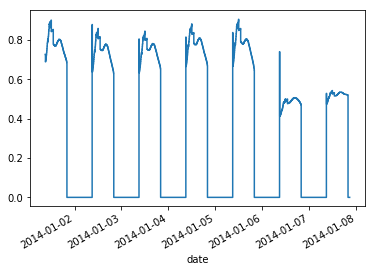

In [12]:
parking_count.groupby(['date'])['perc'].mean().plot(drawstyle='steps-post')

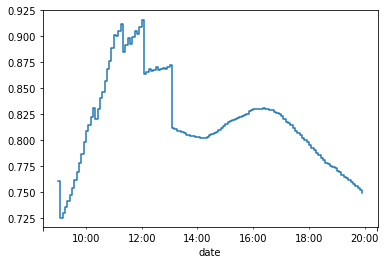

In [13]:
parking_count[(parking_count['weekday']=='Monday') & (parking_count['hour']<=19)].groupby(['date'])['perc'].median().plot(drawstyle='steps-post')

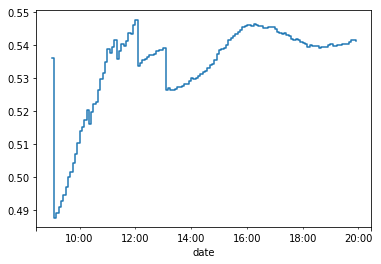

In [14]:
parking_count[(parking_count['weekday']=='Sunday') & (parking_count['hour']<=19)].groupby(['date'])['perc'].median().plot(drawstyle='steps-post')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F8010DBE0>,
      dtype=object)

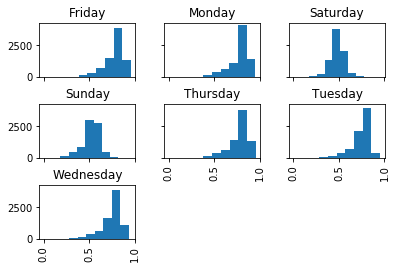

In [15]:
parking_count[parking_count['hour']<=20].groupby(['parkmeter','weekday'])['perc'].median().reset_index().hist(column='perc',by='weekday',sharey=True,sharex=True)

In [16]:
median_by_day = parking_count[parking_count['hour']<=20].groupby(['day','weekday'])['perc'].median()
median_by_day

day  weekday  
1    Monday       0.804878
2    Tuesday      0.762763
3    Wednesday    0.766102
4    Thursday     0.794643
5    Friday       0.793860
6    Saturday     0.474801
7    Sunday       0.525974
Name: perc, dtype: float64

In [17]:
test = parking_count.groupby(['parkmeter','weekday','hour']).mean().reset_index()
count_weekend = test[test['weekday']==('Saturday' or 'Sunday')].groupby('parkmeter')['count'].mean().reset_index()
count_week = test[test['weekday']==('Wednesday' or 'Thuesday')].groupby('parkmeter')['count'].mean().reset_index()

In [18]:
week_parkmeters = list(count_week['parkmeter'][count_week['count'] < count_weekend['count']])

moins_weekend = parking_count[parking_count['parkmeter'].isin(week_parkmeters)]

In [19]:
df = store['transaction_and_locations']
df.head(20)

parkmeter_id user_type payment_method  amount  duration_hours  \
0           66391001   Rotatif             CB    2.40            2.00   
1           66391001   Rotatif    Paris Carte    0.30            0.25   
2084        66391001   Rotatif             CB    0.60            0.50   
2085        66391001   Rotatif             CB    0.90            0.75   
2086        66391001   Rotatif    Paris Carte    0.30            0.25   
2087        66391001   Rotatif    Paris Carte    0.60            0.50   
2088        66391001   Rotatif    Paris Carte    1.20            1.00   
5899        66391001  Résident             CB    3.25           50.00   
7400        66391001   Rotatif             CB    0.90            0.75   
18695       66391001   Rotatif             CB    1.80            1.50   
18696       66391001   Rotatif             CB    2.40            2.00   
18697       66391001   Rotatif             CB    2.40            2.00   
18698       66391001   Rotatif    Paris Carte    0.60            0.50   
18699       66391001   Rotatif    Paris Carte    1.20            1.00   
326709      66391001  Résident    Paris Carte    0.30            4.62   
326710      66391001   Rotatif             CB    1.50            1.25   
326711      66391001   Rotatif    Paris Carte    0.60            0.50   
326712      66391001   Rotatif    Paris Carte    0.90            0.75   
326713      66391001   Rotatif    Paris Carte    1.20            1.00   
372863      66391001   Rotatif    Paris Carte    0.30            0.25   

             parking_start         parking_end    parkmeter_address  \
0      2014-09-09 14:02:44 2014-09-09 16:02:44  121 BOULEVARD MURAT   
1      2014-02-09 14:18:09 2014-02-09 14:33:09  121 BOULEVARD MURAT   
2084   2014-05-09 18:55:21 2014-05-09 19:25:21  121 BOULEVARD MURAT   
2085   2014-08-09 16:30:32 2014-08-09 17:15:32  121 BOULEVARD MURAT   
2086   2014-01-09 18:40:25 2014-01-09 18:55:25  121 BOULEVARD MURAT   
2087   2014-09-09 14:56:33 2014-09-09 16:56:33  121 BOULEVARD MURAT   
2088   2014-04-09 15:20:04 2014-04-09 16:20:04  121 BOULEVARD MURAT   
5899   2014-06-09 11:58:29 2014-12-09 20:00:00  121 BOULEVARD MURAT   
7400   2014-03-09 14:30:40 2014-03-09 15:15:40  121 BOULEVARD MURAT   
18695  2014-05-09 14:53:20 2014-05-09 16:23:20  121 BOULEVARD MURAT   
18696  2014-01-09 17:21:42 2014-01-09 19:21:42  121 BOULEVARD MURAT   
18697  2014-04-09 14:23:37 2014-04-09 16:23:37  121 BOULEVARD MURAT   
18698  2014-05-09 11:23:05 2014-05-09 11:53:05  121 BOULEVARD MURAT   
18699  2014-05-09 13:13:20 2014-05-09 14:13:20  121 BOULEVARD MURAT   
326709 2014-07-28 15:56:58 2014-07-29 15:56:58  121 BOULEVARD MURAT   
326710 2014-07-25 13:13:33 2014-07-25 14:28:33  121 BOULEVARD MURAT   
326711 2014-07-24 15:54:07 2014-07-24 16:24:07  121 BOULEVARD MURAT   
326712 2014-07-25 13:14:51 2014-07-25 13:59:51  121 BOULEVARD MURAT   
326713 2014-07-24 13:04:33 2014-07-24 14:04:33  121 BOULEVARD MURAT   
372863 2014-08-29 16:41:10 2014-01-09 10:15:00  121 BOULEVARD MURAT   

        arrondissement system residential_area  hourly_rate  \
0                   16    MIX              16Z          2.4   
1                   16    MIX              16Z          2.4   
2084                16    MIX              16Z          2.4   
2085                16    MIX              16Z          2.4   
2086                16    MIX              16Z          2.4   
2087                16    MIX              16Z          2.4   
2088                16    MIX              16Z          2.4   
5899                16    MIX              16Z          2.4   
7400                16    MIX              16Z          2.4   
18695               16    MIX              16Z          2.4   
18696               16    MIX              16Z          2.4   
18697               16    MIX              16Z          2.4   
18698               16    MIX              16Z          2.4   
18699               16    MIX              16Z          2.4   
326709              16    MIX        

In [20]:
df['parkmeter_id'].value_counts()

27070208    31509
96230705    28227
18870304    28146
31160904    19241
98500106    19110
31160311    17684
47630902    17628
20100205    16919
18871603    16364
47631001    15858
98530403    15692
47630102    15546
96230303    15503
68750102    15106
98840106    14772
79890104    14597
20150902    14575
88090201    14296
87350105    14032
42710704    13729
36591404    13675
47540102    13662
98530503    13466
97650602    13140
47630801    13100
26570203    13082
20100201    12778
31160802    12644
26570106    12623
77400604    12439
            ...  
48980204      170
21131202      168
97870102      166
86030501      159
66170101      158
98410102      157
75870301      151
80130102      150
46720102      144
17920302      130
59090102      127
86780101      118
10950101      107
1330106        93
48980206       88
55030302       87
10580401       86
6100702        83
29880101       74
3510101        70
44630304       65
25231603       60
33620201       54
54220804       53
22960303  

In [21]:
df['payment_method'].value_counts(normalize=True)

Paris Carte    0.539009
CB             0.460991
Name: payment_method, dtype: float64

In [22]:
df['user_type'].value_counts(normalize=True)

Rotatif     0.778518
Résident    0.221482
Name: user_type, dtype: float64

In [23]:
df['duration_hours'].value_counts(normalize=True,bins=(0,2,9,10,49,50))

(-0.001, 2.0]    0.779736
(49.0, 50.0]     0.121500
(9.0, 10.0]      0.083215
(10.0, 49.0]     0.011235
(2.0, 9.0]       0.004313
Name: duration_hours, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F823FC3C8>,
      dtype=object)

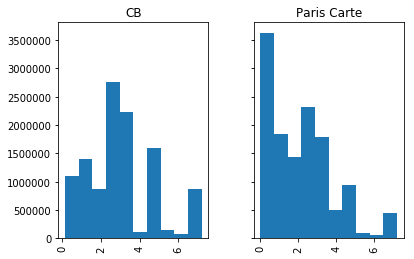

In [24]:
df.hist(column='amount',by='payment_method',sharey=True)

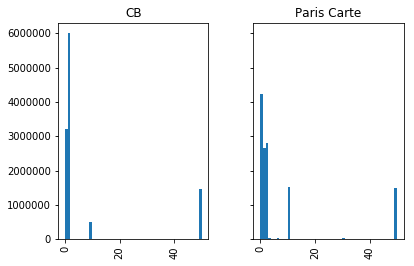

In [25]:
ax = df.hist(column='duration_hours',by='payment_method',sharey=True,bins=50)

In [26]:
df_parkmeter = df.groupby(['parkmeter_id','parkmeter_coordinates','residential_area'])

In [27]:
parkmeter_amount = df_parkmeter['amount'].sum().reset_index()
parkmeter_amount['duration'] = df_parkmeter['duration_hours'].median().reset_index()['duration_hours']
parkmeter_amount.head(20)

parkmeter_id         parkmeter_coordinates residential_area    amount  \
0          20301  48.8541990002, 2.33470999949               6E  11135.68   
1          40102      48.830383, 2.31482099952              14K   5087.55   
2          40202  48.8296970003, 2.31620000015              14K   3663.65   
3          40401       48.82884, 2.31826000035              14K   6222.35   
4          40405  48.8278949997, 2.32043099983              14K  15185.06   
5          60102  48.8433079999, 2.34211300028               5H  12546.34   
6          60202  48.8438679998, 2.33969899934               5H   2135.62   
7          80101  48.8570260003, 2.28092100068              16P   6089.97   
8         100402  48.8472750003, 2.32566599991               6F  15695.36   
9         120104  48.8426530004, 2.29379500058              15P   2597.80   
10        120201  48.8417590001, 2.29480300053              15P   5786.91   
11        120204  48.8413179998, 2.29495799938              15P   6174.21   
12        120302  48.8400059998, 2.29610099956              15V   5478.91   
13        120501  48.8392820001, 2.29717500047              15R   3825.00   
14        120601  48.8384990001, 2.29825900055              15R   3047.65   
15        120702  48.8381139997, 2.29867299968              15S   3769.75   
16        120801  48.8377840002, 2.29941300055              15R   4890.40   
17        120901  48.8369330003, 2.30057299948              15R   3025.84   
18        121003  48.8360170001, 2.30197200052              15R   5005.97   
19        140101  48.8889309998, 2.34143999975              18F   4392.10   

    duration  
0      1.265  
1      2.000  
2      2.000  
3      2.000  
4      2.000  
5      2.000  
6      2.000  
7      2.000  
8      1.500  
9      2.000  
10     2.000  
11     2.000  
12     2.000  
13     2.000  
14     2.000  
15     2.000  
16     2.000  
17     2.000  
18     2.000  
19    10.000

In [28]:
parkmeter_amount['coordinates'] = parkmeter_amount['parkmeter_coordinates'].map(lambda x: (float(x.split(',')[1]),float(x.split(',')[0])))
parkmeter_amount['points'] = parkmeter_amount['coordinates'].apply(Point)

In [29]:
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

In [36]:
nb_places = parking_count[parking_count['hour']<20].groupby('parkmeter')['perc'].median().reset_index()
nb_places['count'] = parking_count.groupby('parkmeter')['count'].max().reset_index()['count']
nb_places['perc week'] = parking_count[(parking_count['hour']<20)&(parking_count['day']<=5)].groupby('parkmeter')['perc'].median().reset_index()['perc']
nb_places['perc weekend'] = parking_count[(parking_count['hour']<20)&(parking_count['day']>=6)].groupby('parkmeter')['perc'].median().reset_index()['perc']
nb_places['perc tot'] = parking_count[(parking_count['hour']<20)].groupby('parkmeter')['perc'].median().reset_index()['perc']
df_places = pd.merge(nb_places,parkmeter_amount.rename(columns={'parkmeter_id':'parkmeter'}),on='parkmeter')

df_places['€/place'] = df_places['amount']/nb_places['count']
gdf = geopandas.GeoDataFrame(df_places, geometry='points')

In [37]:
df_places.head()

parkmeter      perc  count  perc week  perc weekend  perc tot  \
0      20301  0.780919    283   0.802120      0.528269  0.780919   
1      40102  0.811881    303   0.841584      0.554455  0.811881   
2      40202  0.748106    264   0.776515      0.507576  0.748106   
3      40401  0.790588    425   0.818824      0.545882  0.790588   
4      40405  0.824289    774   0.861757      0.565245  0.824289   

          parkmeter_coordinates residential_area    amount  duration  \
0  48.8541990002, 2.33470999949               6E  11135.68     1.265   
1      48.830383, 2.31482099952              14K   5087.55     2.000   
2  48.8296970003, 2.31620000015              14K   3663.65     2.000   
3       48.82884, 2.31826000035              14K   6222.35     2.000   
4  48.8278949997, 2.32043099983              14K  15185.06     2.000   

                      coordinates                               points  \
0  (2.33470999949, 48.8541990002)  POINT (2.33470999949 48.8541990002)   
1      (2.31482099952, 48.830383)      POINT (2.31482099952 48.830383)   
2  (2.31620000015, 48.8296970003)  POINT (2.31620000015 48.8296970003)   
3       (2.31826000035, 48.82884)       POINT (2.31826000035 48.82884)   
4  (2.32043099983, 48.8278949997)  POINT (2.32043099983 48.8278949997)   

     €/place  
0  39.348693  
1  16.790594  
2  13.877462  
3  14.640824  
4  19.618941

In [38]:
city = geopandas.read_file('./residentiels.geojson')
arg_places = (df_places.groupby('residential_area')['amount'].sum()/df_places.groupby('residential_area')['count'].sum()).reset_index()
city = pd.merge(city,arg_places.rename(columns={'residential_area':'nom',0:'€/place'}),on='nom')
noms=[]
def fun(x):
    if x in noms:
        return noms.index(x)
    else:
        noms.append(x)
        return len(noms)-1
city['id'] = city['nom'].map(fun)
gdf['residential_id'] = gdf['residential_area'].map(lambda x: noms.index(x))
city.head(10)

shape_len  nom  shape_area  objectid  \
0        0.0  13H         0.0         8   
1        0.0  15R         0.0        57   
2        0.0  15U         0.0        58   
3        0.0   7H         0.0        13   
4        0.0  16G         0.0        43   
5        0.0  16F         0.0        44   
6        0.0  18P         0.0        37   
7        0.0  18H         0.0        39   
8        0.0  16Y         0.0        20   
9        0.0   7N         0.0        23   

                                            geometry    €/place  id  
0  POLYGON ((2.342799442212257 48.83136484712755,...  24.908742   0  
1  POLYGON ((2.298924402240968 48.83803877504592,...  16.617582   1  
2  POLYGON ((2.288498269517315 48.82876101047022,...  15.770135   2  
3  POLYGON ((2.304533115448992 48.84896184186745,...  24.583240   3  
4  POLYGON ((2.295791220959695 48.86799994492451,...  45.506759   4  
5  POLYGON ((2.287682996808664 48.86939849297134,...  31.496720   5  
6  POLYGON ((2.33193622586821 48.89213637479703, ...  14.202792   6  
7  POLYGON ((2.349523152241182 48.88527880955324,...  14.082356   7  
8  POLYGON ((2.256861313678262 48.83879363761998,...  15.425361   8  
9  POLYGON ((2.311951673578781 48.84709488391012,...  40.119105   9

In [39]:
zones_tarifaires = geopandas.read_file('./zones-tarifaires.geojson')
zones_tarifaires.head()

shape_area  objectid zone  shape_len  tarif  \
0         0.0         1    1        0.0    4.0   
1         0.0        12    2        0.0    2.4   

                                            geometry  
0  POLYGON ((2.339776543083362 48.88202934722508,...  
1  (POLYGON ((2.399469443152347 48.88495814419404...

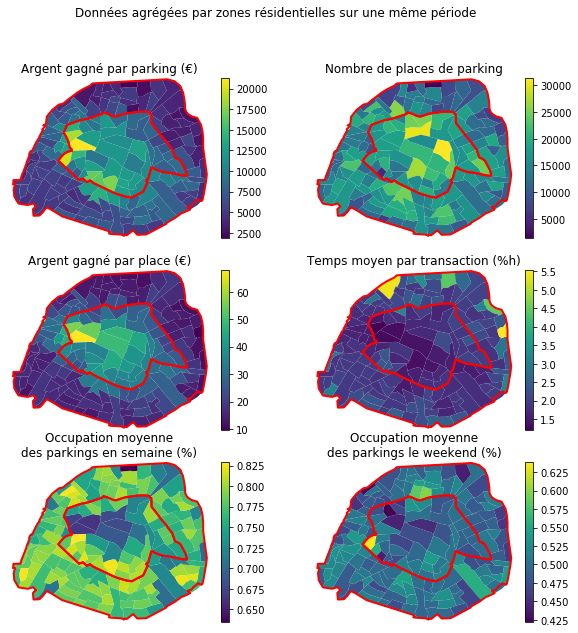

In [35]:
f, axarr = plt.subplots(3, 2, figsize=(10, 10), subplot_kw={'projection': gcrs.AlbersEqualArea()})
axarr = axarr.flatten()

f.suptitle('Données agrégées par zones résidentielles sur une même période')
axarr[0].set_title('Argent gagné par parking (€)')
gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='amount',
             by='residential_id', geometry=city.geometry, agg=np.mean, ax=axarr[0],
             linewidth=0)

axarr[1].set_title('Nombre de places de parking')
gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='count',
             by='residential_id', geometry=city.geometry, agg=np.sum, ax=axarr[1],
             linewidth=0)

axarr[2].set_title('Argent gagné par place (€)')
gplt.aggplot(city, projection=gcrs.AlbersEqualArea(), hue='€/place',
             by='id', geometry=city.geometry, agg=np.mean, ax=axarr[2],
             linewidth=0)

axarr[3].set_title('Temps moyen par transaction (%h)')
gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='duration',
             by='residential_id', geometry=city.geometry, agg=np.mean, ax=axarr[3],
             linewidth=0)

axarr[4].set_title('Occupation moyenne\ndes parkings en semaine (%)')
gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='perc week',
             by='residential_id', geometry=city.geometry, agg=np.mean, ax=axarr[4],
             linewidth=0)

axarr[5].set_title('Occupation moyenne\ndes parkings le weekend (%)')
gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='perc weekend',
             by='residential_id', geometry=city.geometry, agg=np.mean, ax=axarr[5],
             linewidth=0)

gplt.polyplot(zones_tarifaires,projection=gcrs.AlbersEqualArea(),edgecolor='red',linewidth=2,ax=axarr[0])
gplt.polyplot(zones_tarifaires,projection=gcrs.AlbersEqualArea(),edgecolor='red',linewidth=2,ax=axarr[1])
gplt.polyplot(zones_tarifaires,projection=gcrs.AlbersEqualArea(),edgecolor='red',linewidth=2,ax=axarr[2])
gplt.polyplot(zones_tarifaires,projection=gcrs.AlbersEqualArea(),edgecolor='red',linewidth=2,ax=axarr[3])
gplt.polyplot(zones_tarifaires,projection=gcrs.AlbersEqualArea(),edgecolor='red',linewidth=2,ax=axarr[4])
gplt.polyplot(zones_tarifaires,projection=gcrs.AlbersEqualArea(),edgecolor='red',linewidth=2,ax=axarr[5])

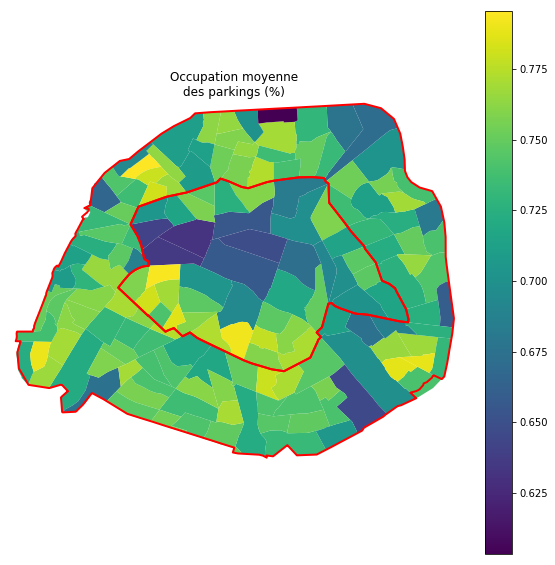

In [41]:
f, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': gcrs.AlbersEqualArea()})
ax.set_title('Occupation moyenne\ndes parkings (%)')
gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='perc tot',
             by='residential_id', geometry=city.geometry, agg=np.mean, ax=ax,
             linewidth=0)
gplt.polyplot(zones_tarifaires,projection=gcrs.AlbersEqualArea(),edgecolor='red',linewidth=2,ax=ax)

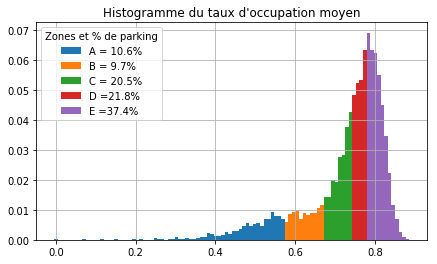

In [166]:
f,ax = plt.subplots(1,1,figsize=(7,4))
hist, bins = np.histogram(gdf['perc tot'],bins=100)
hist = hist.astype(np.float32) / hist.sum()


width=(bins[1]-bins[0])
zones = [0,0.575,0.675,0.75,0.78,1]
bar_range = []
hist_range=[]
for k in range(1,len(zones)):
    r=[]
    h=[]
    for i in range(len(bins[:-1])):
        if zones[k-1] <= bins[i]+width/2 and bins[i]+width/2 < zones[k]:
            r.append(bins[i])
            h.append(hist[i])
    bar_range.append(r[:])
    hist_range.append(h[:])
    
    
for bar,h in zip(bar_range,hist_range):
    plt.bar(bar, h, width=width)
tot = [100*sum(h) for h in hist_range]
def zones_legend(tot):
    return 'A = {0:.1f}%;B = {1:.1f}%;C = {2:.1f}%;D ={3:.1f}%;E ={4:.1f}%'.format(*tot).split(';')
ax.set_title("Histogramme du taux d'occupation moyen")
ax.legend(zones_legend(tot),title='Zones et % de parking')
ax.grid(True)

In [198]:
inside = gdf['geometry'].map(lambda x:x.intersects(zones_tarifaires.iloc[0]['geometry']))
outside = gdf['geometry'].map(lambda x: not x.intersects(zones_tarifaires.iloc[0]['geometry']))
gdf['inside']=inside
count_inside = gdf['count'][inside].sum() / inside.sum()
perc_inside = gdf['perc tot'][inside].sum() / inside.sum()
count_outside = gdf['count'][outside].sum() / outside.sum()
perc_outside = gdf['perc tot'][outside].sum() / outside.sum()


print(count_inside,count_outside)
print(perc_inside,perc_outside)

322.4231860559384 319.3287748220307
0.7170379545841531 0.7386717167098842


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F96B7EE48>,
      dtype=object)

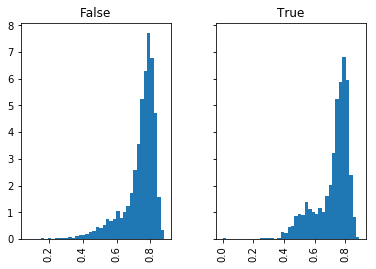

In [202]:
gdf.hist(column='perc tot',by='inside',sharey=True,density=True,bins=40)

In [204]:
print((70-61)/(4-2.4),'%/€')

5.625 %/€
